# Chapter 9- Support Vector Machines

The following excercises, code, and explanations are adapted from An Introduction to Statistical Learning with Applications in Python (ISLP) (James, Witten, Hastie, Tibshirani, and Taylor 2023).

## Instructor Code

Make sure the following packages are installed prior to running code in this notebook:

In [25]:
#Load required packages
import ISLP
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import GridSearchCV
from sklearn import preprocessing
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import seaborn as sns



# Exercise: `OJ` dataset
This exercise is adapted from Chapter 9, Exercise 8 in ISLP. 
This problem invovles the `OJ` data set which is part of the `ISLP` package.

This data pertains to Orange Juice purchases where customers bought either Citrus Hill (CH) or Minute Maid (MM) Brand Orange Juice. We'll start by reading in the data.

In [26]:
# load data
df = ISLP.load_data("OJ")

In [27]:
df.head(10) # data preview

,Purchase,WeekofPurchase,StoreID,PriceCH,PriceMM,DiscCH,DiscMM,SpecialCH,SpecialMM,LoyalCH,SalePriceMM,SalePriceCH,PriceDiff,Store7,PctDiscMM,PctDiscCH,ListPriceDiff,STORE
0,CH,237,1,1.75,1.99,0.00,0.0,0,0,0.500000,1.99,1.75,0.24,No,0.000000,0.000000,0.24,1
1,CH,239,1,1.75,1.99,0.00,0.3,0,1,0.600000,1.69,1.75,-0.06,No,0.150754,0.000000,0.24,1
2,CH,245,1,1.86,2.09,0.17,0.0,0,0,0.680000,2.09,1.69,0.40,No,0.000000,0.091398,0.23,1
3,MM,227,1,1.69,1.69,0.00,0.0,0,0,0.400000,1.69,1.69,0.00,No,0.000000,0.000000,0.00,1
4,CH,228,7,1.69,1.69,0.00,0.0,0,0,0.956535,1.69,1.69,0.00,Yes,0.000000,0.000000,0.00,0
5,CH,230,7,1.69,1.99,0.00,0.0,0,1,0.965228,1.99,1.69,0.30,Yes,0.000000,0.000000,0.30,0
6,CH,232,7,1.69,1.99,0.00,0.4,1,1,0.972182,1.59,1.69,-0.10,Yes,0.201005,0.000000,0.30,0
7,CH,234,7,1.75,1.99,0.00,0.4,1,0,0.977746,1.59,1.75,-0.16,Yes,0.201005,0.000000,0.24,0
8,CH,235,7,1.75,1.99,0.00,0.4,0,0,0.982197,1.59,1.75,-0.16,Yes,0.201005,0.000000,0.24,0
9,CH,238,7,1.75,1.99,0.00,0.4,0,0,0.985757,1.59,1.75,-0.16,Yes,0.201005,0.000000,0.24,0


The `Purchase` column reflects the brand of OJ purchased - this will be our response variable that we want to classify our observations by.  The rest of the columns reflect different characteristics about the customer, product, and sale (including discounts, price, store location, etc).  For a description of all variables, see [https://intro-stat-learning.github.io/ISLP/datasets/OJ.html](https://intro-stat-learning.github.io/ISLP/datasets/OJ.html).

In [28]:
# Number of rows and columns
df.shape

(1070, 18)

The code above shows that there are a total of 1070 observations and 18 variables.  We have a mix of both categorical and continous variables.  Since we can't visualize all variables at the same time, we'll instead plot each pair of variables.  Note that variable `Store7` is not plotted because it is categorical (Yes if purchase made at store 7, No otherwise) - in practice you'd want to visualize this variable too but we'll skip it for today's course since data visualization is not the focus.  

In the plot below, `CH` = red and `MM` = blue.

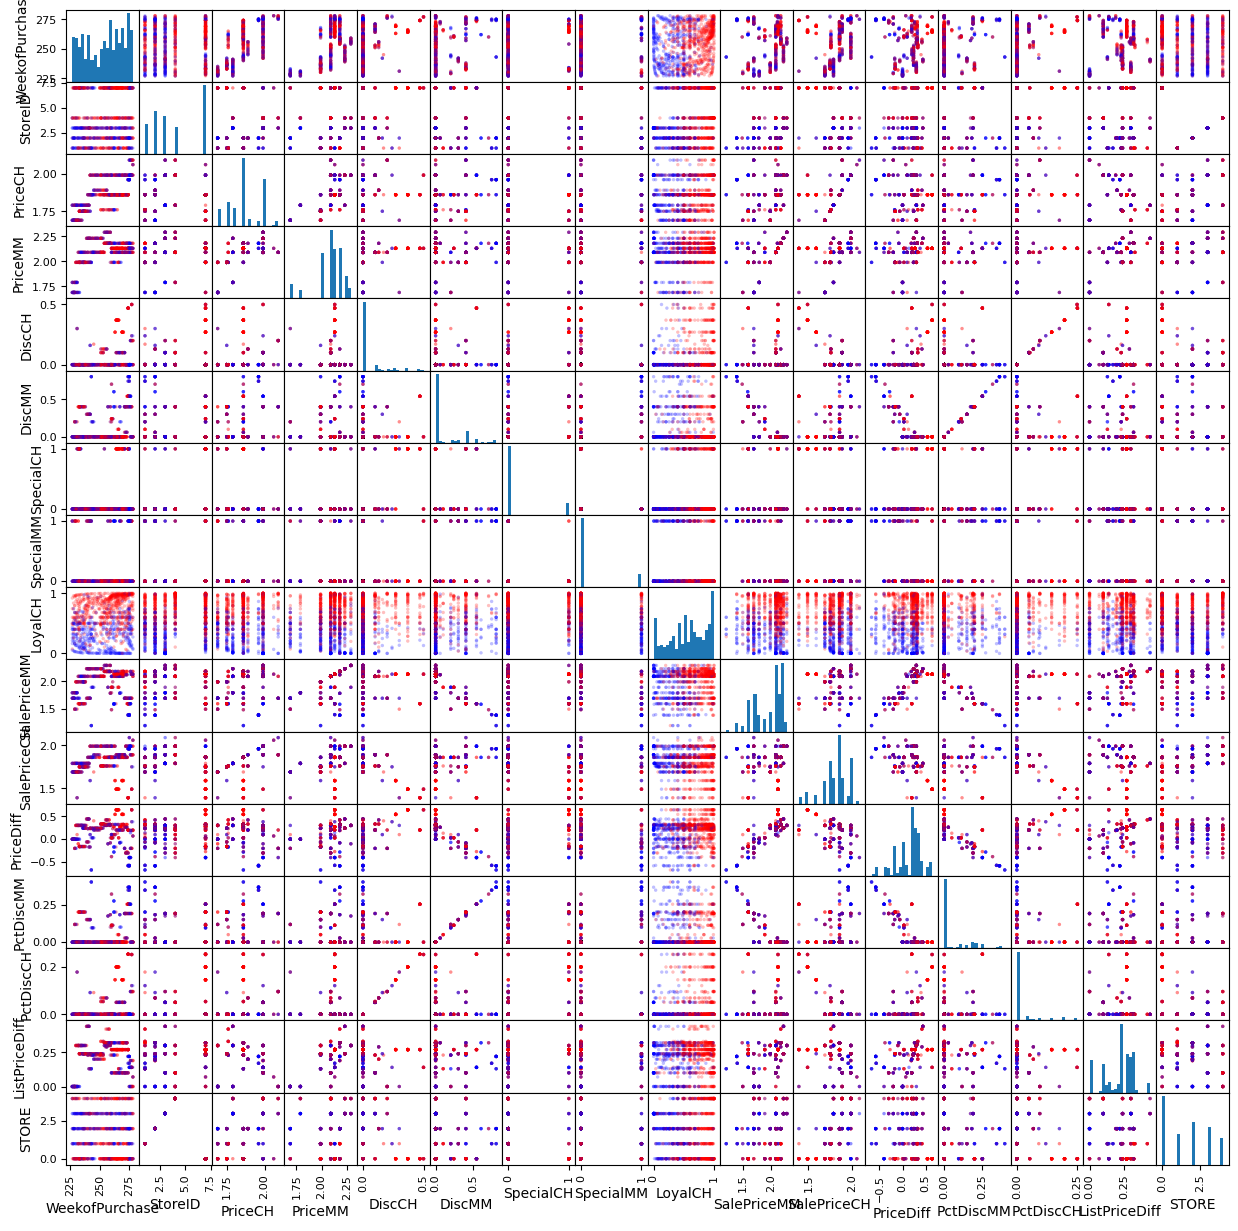

In [29]:
pd.plotting.scatter_matrix(df, figsize=(15, 15), marker='o', hist_kwds={'bins': 20}, s=6, alpha=.25,
                           range_padding=0.2, color=['red' if x == 'CH' else 'blue' for x in df['Purchase']]);

There's alot to look at here!  Notice that it's not as straightfoward to draw a straight dividing line in many of these plots.  This is even more complicated in 17 dimensions using all predictor variables.  

Some have more clear patterns than others.  For example, the `LoyalCH` variable represents how loyal each customer is to the Citrus Hill Brand.  Naturally, those who are more loyal to the brand are more likely to buy Citrus Hill, so we see more red points on the right had side of each plot in the `LoyalCH` column.  It may make sense to divide these pairs roughly around `LoyalCH=0.5`.

(a) Create a training set containing a random sample of 800 observations, and a test set containing the remaining observations.

In [30]:
# Define predictors and response 
X = df.drop(axis=1, labels=['Purchase'])
y = df['Purchase']

In [31]:
# transfer dummy variables
X = pd.get_dummies(X)
# scale data
X = preprocessing.scale(X)

In [32]:
# Split data into train and test set
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=800, random_state=1)

(b) Fit a support vector classifier to the training data using `C=0.01`, with `Purchase` as the response and the other variables as predictor. How many support points are there?

Recall that `C` is our tuning parameter that can be considered as the "budget" or "cost" for the amount that the margin can be violated
by the n observations.  

In [33]:
# Fit SVC
svc = SVC(C=0.01, kernel='linear')
svc.fit(X_train, y_train)

,C,0.01
,kernel,'linear'
,degree,3
,gamma,'scale'
,coef0,0.0
,shrinking,True
,probability,False
,tol,0.001
,cache_size,200
,class_weight,None
,verbose,False


In [34]:
# Number of support vectors for each class
svc.n_support_

array([217, 216], dtype=int32)

In our dataset, we have 800 observations, 2 classes, and a total of 611 support vectors. From those support vectors, 217 belong to class CH and 216 to class MM.

In [35]:
# Example of other arguments you can set in SVC - we are not actually using this call to SVC
SVC(C=0.01, cache_size=200, class_weight=None, coef0=0.0,
   degree=3, gamma='auto', kernel='linear',
  max_iter=-1, probability=False, random_state=1, shrinking=True,
  tol=0.001, verbose=False)

,C,0.01
,kernel,'linear'
,degree,3
,gamma,'auto'
,coef0,0.0
,shrinking,True
,probability,False
,tol,0.001
,cache_size,200
,class_weight,None
,verbose,False


(c) What are the training and test error rates?

In [36]:
# Make predictions
train_predictions = svc.predict(X_train)
test_predictions = svc.predict(X_test)

# Calculate accuracy
train_accuracy = accuracy_score(y_train, train_predictions)
test_accuracy = accuracy_score(y_test, test_predictions)

# Calculate error rates
train_error_rate = 1 - train_accuracy
test_error_rate = 1 - test_accuracy

# Print results
print(f"Training Error Rate: {train_error_rate:.5f}")
print(f"Testing Error Rate: {test_error_rate:.5f}")

Training Error Rate: 0.16750
Testing Error Rate: 0.16667


Confusion Matrix (Test):
[[144  13]
 [ 32  81]]


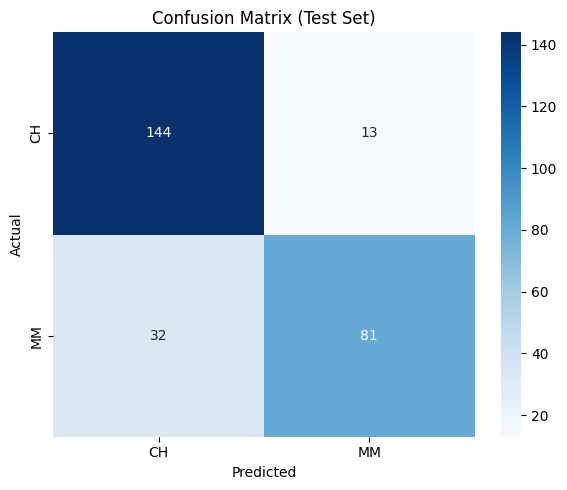

In [37]:
# --- Confusion Matrix ---
# For test set
cm = confusion_matrix(y_test, test_predictions)
print("Confusion Matrix (Test):")
print(cm)

# Prettier plot with unique class labels
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=np.unique(y_test), yticklabels=np.unique(y_test))
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix (Test Set)")
plt.tight_layout()
plt.show()

(d) Use cross-validation to select an optimal `C`. Consider values in the range 0.01 to 10.

Since the selection of an optimal cost is a hypertuning parameter operation, we will use the GridSearchCV.

In [38]:
# Hypertune cost using GridSearchCV
svc = SVC(kernel='linear')

parameters = {'C':np.arange(0.01, 10, 2)}

clf = GridSearchCV(svc, parameters)
clf.fit(X_train, y_train)

,estimator,SVC(kernel='linear')
,param_grid,"{'C': array([0.01, ..., 6.01, 8.01])}"
,scoring,None
,n_jobs,None
,refit,True
,cv,None
,verbose,0
,pre_dispatch,'2*n_jobs'
,error_score,nan
,return_train_score,False
,C,8.01


In [39]:
# Best value for cost
clf.best_params_

{'C': 8.01}

(e) Compute the traning and test error rates using this new value for `C`.

In [40]:
# Make predictions
train_predictions = clf.predict(X_train)
test_predictions = clf.predict(X_test)

# Calculate accuracy
train_accuracy = accuracy_score(y_train, train_predictions)
test_accuracy = accuracy_score(y_test, test_predictions)

# Calculate error rates
train_error_rate = 1 - train_accuracy
test_error_rate = 1 - test_accuracy

# Print results
print(f"Training Error Rate: {train_error_rate:.5f}")
print(f"Testing Error Rate: {test_error_rate:.5f}")

Training Error Rate: 0.16125
Testing Error Rate: 0.17037


Confusion Matrix (Test):
[[141  16]
 [ 30  83]]


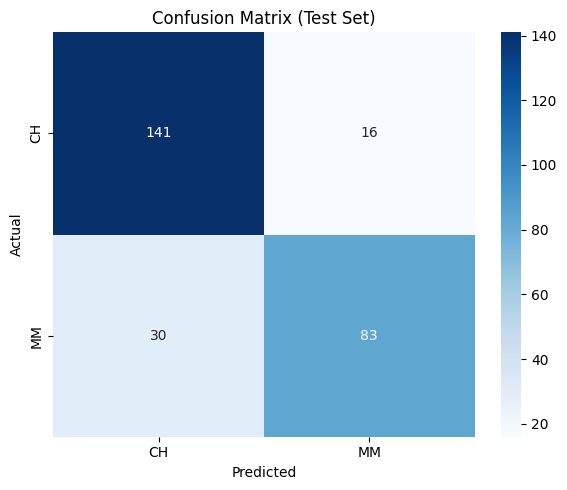

In [41]:
# --- Confusion Matrix ---
# For test set
cm = confusion_matrix(y_test, test_predictions)
print("Confusion Matrix (Test):")
print(cm)

# Prettier plot with unique class labels
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=np.unique(y_test), yticklabels=np.unique(y_test))
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix (Test Set)")
plt.tight_layout()
plt.show()

(f) Repeat parts (b) through (e) using a support vector machine with a radial kernel. Use the default rate for `gamma`.

In [42]:
# Fit SVC to data
svc = SVC(C=0.01, kernel='rbf')
svc.fit(X_train, y_train)

,C,0.01
,kernel,'rbf'
,degree,3
,gamma,'scale'
,coef0,0.0
,shrinking,True
,probability,False
,tol,0.001
,cache_size,200
,class_weight,None
,verbose,False


In [43]:
# Number of support vectors for each class
svc.n_support_

array([308, 304], dtype=int32)

In [44]:
# Make predictions
train_predictions = svc.predict(X_train)
test_predictions = svc.predict(X_test)

# Calculate accuracy
train_accuracy = accuracy_score(y_train, train_predictions)
test_accuracy = accuracy_score(y_test, test_predictions)

# Calculate error rates
train_error_rate = 1 - train_accuracy
test_error_rate = 1 - test_accuracy

# Print results
print(f"Training Error Rate: {train_error_rate:.5f}")
print(f"Testing Error Rate: {test_error_rate:.5f}")

Training Error Rate: 0.38000
Testing Error Rate: 0.41852


Confusion Matrix (Test):
[[157   0]
 [113   0]]


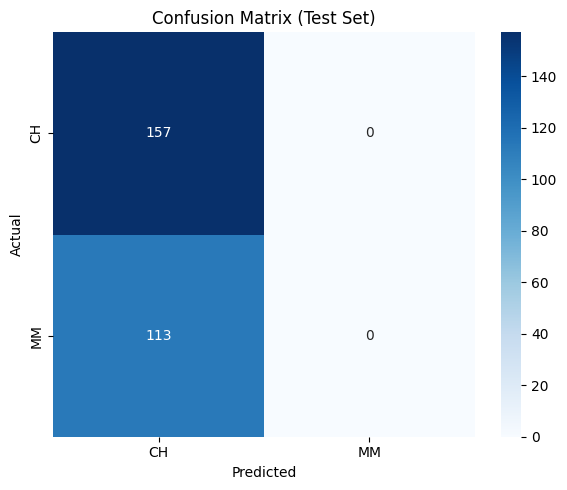

In [45]:
# --- Confusion Matrix ---
# For test set
cm = confusion_matrix(y_test, test_predictions)
print("Confusion Matrix (Test):")
print(cm)

# Prettier plot with unique class labels
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=np.unique(y_test), yticklabels=np.unique(y_test))
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix (Test Set)")
plt.tight_layout()
plt.show()

In [46]:
# Hypertune cost using GridSearchCV
svc = SVC(kernel='rbf')

parameters = {'C':np.arange(0.01, 10, 2)}

clf = GridSearchCV(svc, parameters)
clf.fit(X_train, y_train)

,estimator,SVC()
,param_grid,"{'C': array([0.01, ..., 6.01, 8.01])}"
,scoring,None
,n_jobs,None
,refit,True
,cv,None
,verbose,0
,pre_dispatch,'2*n_jobs'
,error_score,nan
,return_train_score,False
,C,2.01


In [47]:
# Best value for cost
clf.best_params_

{'C': 2.01}

In [48]:
# Make predictions
train_predictions = clf.predict(X_train)
test_predictions = clf.predict(X_test)

# Calculate accuracy
train_accuracy = accuracy_score(y_train, train_predictions)
test_accuracy = accuracy_score(y_test, test_predictions)

# Calculate error rates
train_error_rate = 1 - train_accuracy
test_error_rate = 1 - test_accuracy

# Print results
print(f"Training Error Rate: {train_error_rate:.5f}")
print(f"Testing Error Rate: {test_error_rate:.5f}")

Training Error Rate: 0.15125
Testing Error Rate: 0.19630


Confusion Matrix (Test):
[[145  12]
 [ 41  72]]


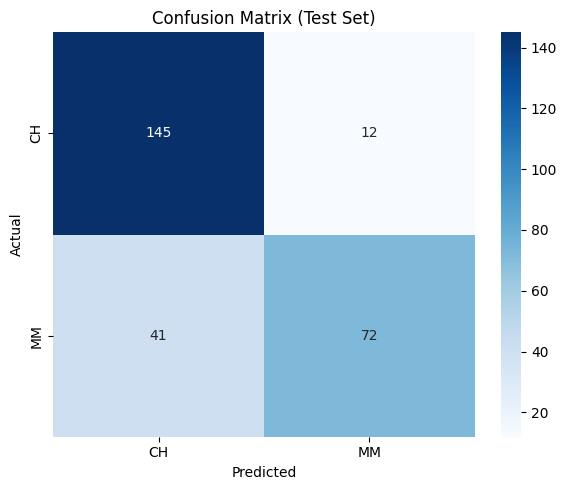

In [49]:
# --- Confusion Matrix ---
# For test set
cm = confusion_matrix(y_test, test_predictions)
print("Confusion Matrix (Test):")
print(cm)

# Prettier plot with unique class labels
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=np.unique(y_test), yticklabels=np.unique(y_test))
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix (Test Set)")
plt.tight_layout()
plt.show()

(g) Repeat parts (b) through (e) using a support vector machine with a polynomial kernel. Set `degree = 2`.

In [50]:
# Fit SVC to data
svc = SVC(C=0.01, kernel='poly', degree=2)
svc.fit(X_train, y_train)

# Number of support vectors for each class
svc.n_support_

array([308, 304], dtype=int32)

In [51]:
# Make predictions
train_predictions = svc.predict(X_train)
test_predictions = svc.predict(X_test)

# Calculate accuracy
train_accuracy = accuracy_score(y_train, train_predictions)
test_accuracy = accuracy_score(y_test, test_predictions)

# Calculate error rates
train_error_rate = 1 - train_accuracy
test_error_rate = 1 - test_accuracy

# Print results
print(f"Training Error Rate: {train_error_rate:.5f}")
print(f"Testing Error Rate: {test_error_rate:.5f}")

Training Error Rate: 0.38000
Testing Error Rate: 0.41852


Confusion Matrix (Test):
[[157   0]
 [113   0]]


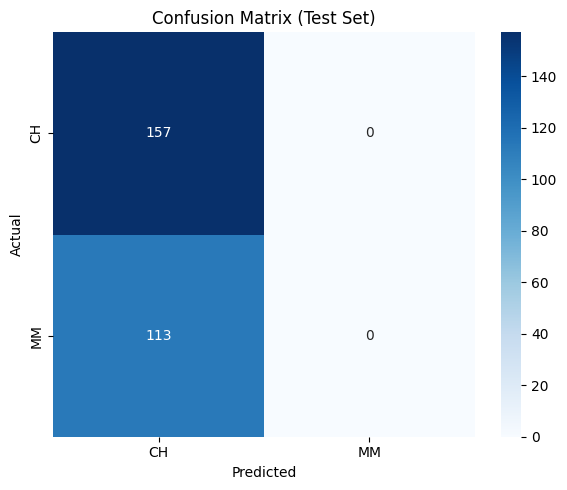

In [52]:
# --- Confusion Matrix ---
# For test set
cm = confusion_matrix(y_test, test_predictions)
print("Confusion Matrix (Test):")
print(cm)

# Prettier plot with unique class labels
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=np.unique(y_test), yticklabels=np.unique(y_test))
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix (Test Set)")
plt.tight_layout()
plt.show()

In [53]:
# Hypertune cost using GridSearchCV
svc = SVC(kernel='poly', degree=2)

parameters = {'C':np.arange(0.01, 10, 2)}

clf = GridSearchCV(svc, parameters)
clf.fit(X_train, y_train)

# Best value for cost
clf.best_params_

{'C': 4.01}

In [54]:
# Make predictions
train_predictions = clf.predict(X_train)
test_predictions = clf.predict(X_test)

# Calculate accuracy
train_accuracy = accuracy_score(y_train, train_predictions)
test_accuracy = accuracy_score(y_test, test_predictions)

# Calculate error rates
train_error_rate = 1 - train_accuracy
test_error_rate = 1 - test_accuracy

# Print results
print(f"Training Error Rate: {train_error_rate:.5f}")
print(f"Testing Error Rate: {test_error_rate:.5f}")

Training Error Rate: 0.21500
Testing Error Rate: 0.27407


Confusion Matrix (Test):
[[140  17]
 [ 57  56]]


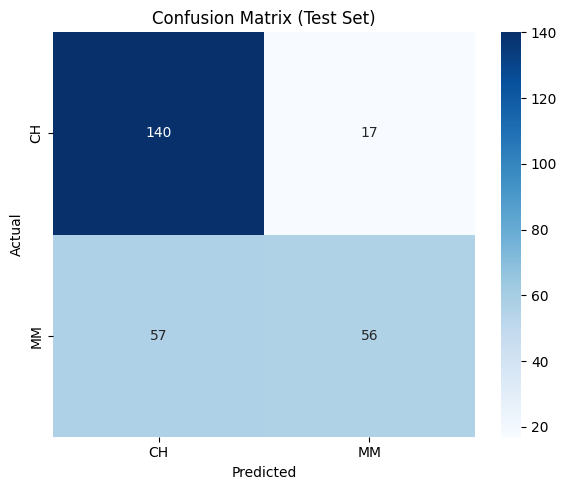

In [55]:
# --- Confusion Matrix ---
# For test set
cm = confusion_matrix(y_test, test_predictions)
print("Confusion Matrix (Test):")
print(cm)

# Prettier plot with unique class labels
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=np.unique(y_test), yticklabels=np.unique(y_test))
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix (Test Set)")
plt.tight_layout()
plt.show()

(h)  Overall, linear SVM seems to perform best on this data.